<a href="https://colab.research.google.com/github/douglasmasho/MedAlgo/blob/main/MedalgoclassifierKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install keras

In [11]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/medalgo2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [12]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [13]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [14]:
import os

def get_data_labels(directory):
    paths = []
    labels = []

    # Iterate over the folders in the directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        # Check if the path is a directory
        if os.path.isdir(label_path):
            # Iterate over the files in the directory
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Add file path and corresponding label
                paths.append(file_path)
                labels.append(label)

    return paths, labels

# Assuming the structure is /content/Training/<label>/<file> and /content/Testing/<label>/<file>
file1 = "/content/Training"
file2 = "/content/Testing"

# Getting data using the function
train_paths, train_labels = get_data_labels(file1)
test_paths, test_labels = get_data_labels(file2)

print('Training Set')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting Set')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training Set
Number of Paths: 5712
Number of Labels: 5712

Testing Set
Number of Paths: 1311
Number of Labels: 1311


In [16]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(file1,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(file2,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [17]:
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Display categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [27]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 50

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

In [28]:
# Define the model architecture
model = models.Sequential([

    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
!pip install visualkeras

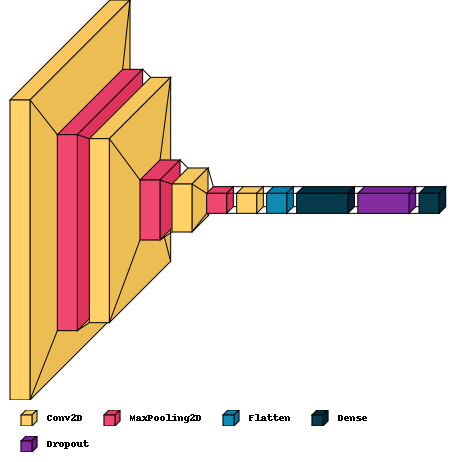

In [30]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

In [31]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 78s 351ms/step - accuracy: 0.4905 - loss: 1.0625 - val_accuracy: 0.6914 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7188 - loss: 0.4951

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7188 - loss: 0.4951 - val_accuracy: 0.9677 - val_loss: 0.1639 - learning_rate: 0.0010
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 246ms/step - accuracy: 0.7840 - loss: 0.5276 - val_accuracy: 0.7844 - val_loss: 0.5022 - learning_rate: 0.0010
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - accuracy: 0.8125 - loss: 0.4158 - val_accuracy: 0.9677 - val_loss: 0.1585 - learning_rate: 0.0010
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 81s 243ms/step - accuracy: 0.8235 - loss: 0.4470 - val_accuracy: 0.7078 - val_loss: 0.7273 - learning_rate: 0.0010
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.7500 - loss: 0.6362 - val_accuracy: 1.0000 - val_loss: 0.1204 - learning_rate: 0.0010
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.8622 - loss: 0.3623 - val_accuracy: 0.8875 - val_loss: 0.3178 - learning_rate: 0.0010
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - accuracy: 0.9375 - loss: 0.224

In [32]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9688 - loss: 0.1055
Test Loss: 0.08154
Test Accuracy: 0.97344


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step


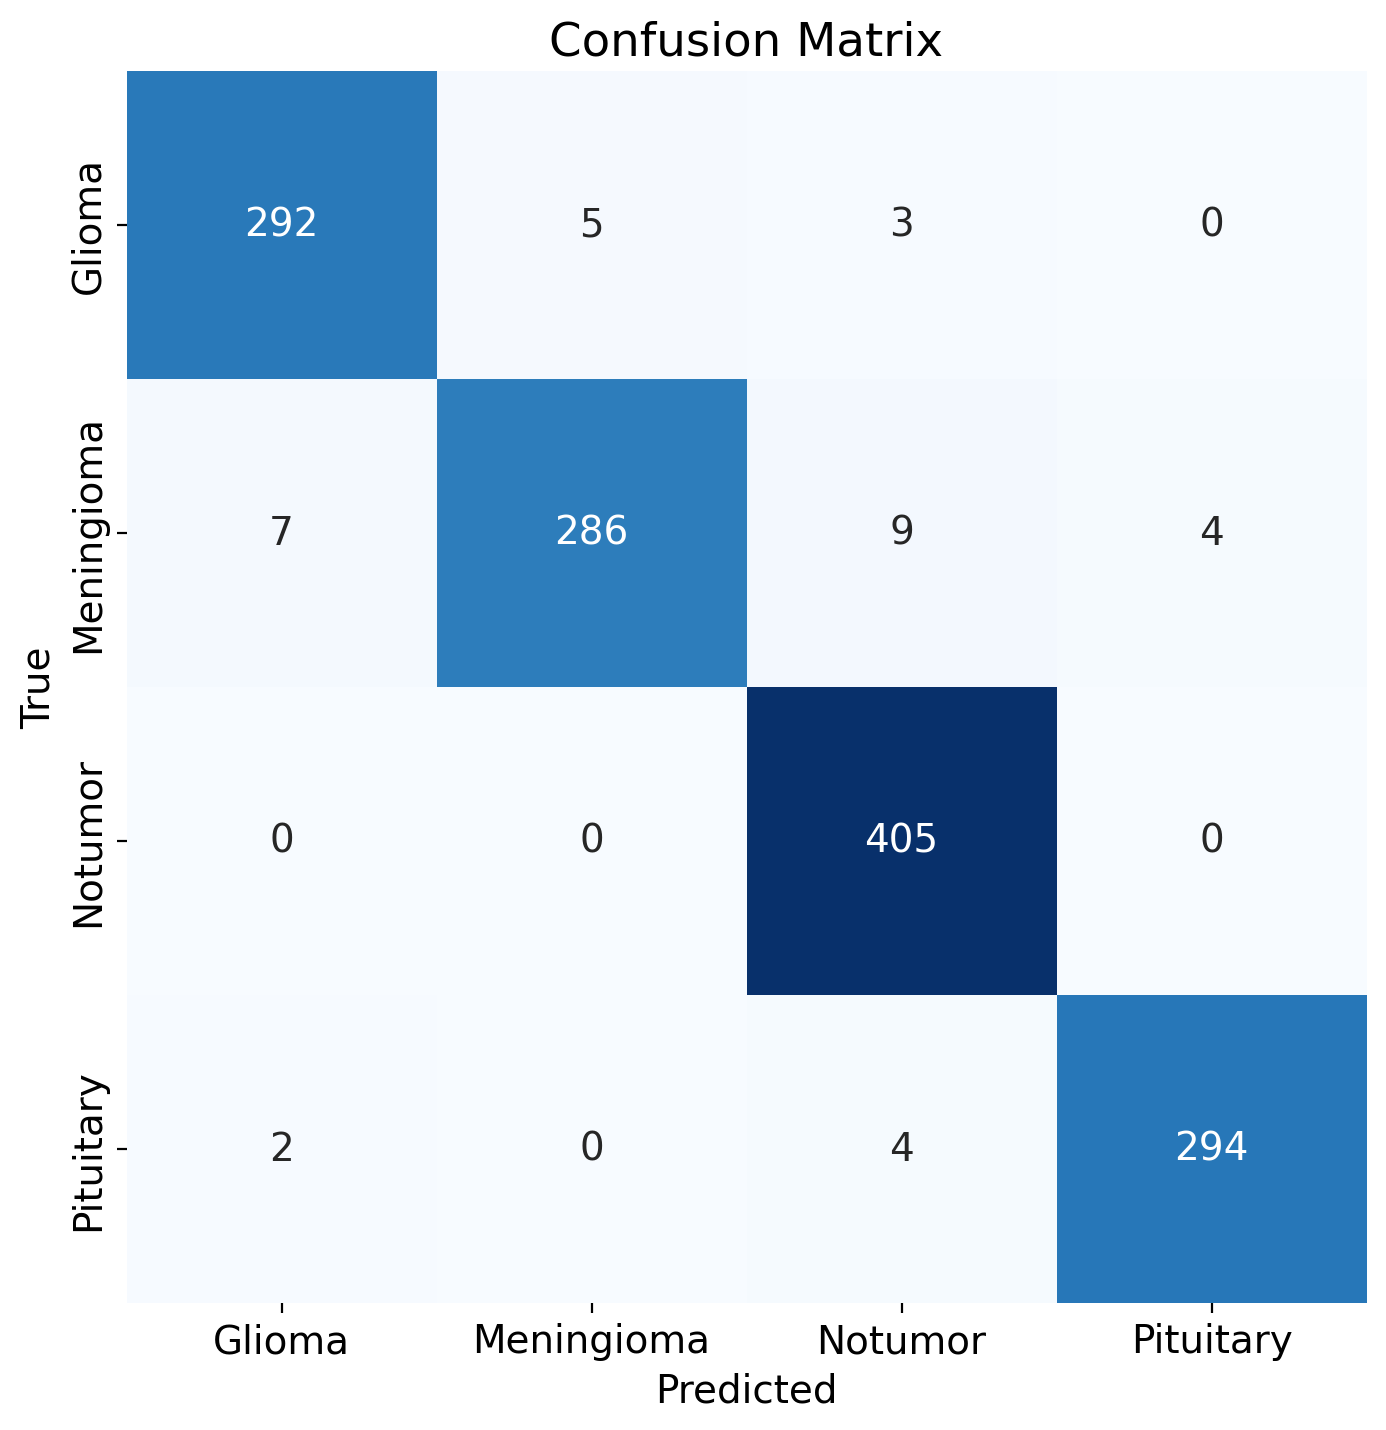

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the model and test_generator defined
# y_true and y_pred will be needed to create the confusion matrix

# Getting true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Create confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

y = plt.imread("/content/no.jpg")
plt.imshow(y)
def prep(image):
  IMG_SIZE=384
  img_array = cv2.imread("/content/no.jpg", cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y=cnn.predict([prep("/content/no.jpg")])
print(np.argmax(y))

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

y = plt.imread("/content/no2.jpg")
plt.imshow(y)
def prep(image):
  IMG_SIZE=384
  img_array = cv2.imread("/content/no2.jpg", cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y=cnn.predict([prep("/content/no2.jpg")])
print(np.argmax(y))

In [ ]:
np.argmax(y)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

y = plt.imread("/content/pituitary.jpg")
plt.imshow(y)
def prep(image):
  IMG_SIZE=384
  img_array = cv2.imread("/content/pituitary.jpg", cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y=cnn.predict([prep("/content/pituitary.jpg")])
print(np.argmax(y))

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

y = plt.imread("/content/no3.jpg")
plt.imshow(y)
def prep(image):
  IMG_SIZE=384
  img_array = cv2.imread("/content/no3.jpg", cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y=cnn.predict([prep("/content/no3.jpg")])
print(np.argmax(y))

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

y = plt.imread("/content/healthy.png")
plt.imshow(y)
def prep(image):
  IMG_SIZE=384
  img_array = cv2.imread("/content/healthy.png", cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y=cnn.predict([prep("/content/healthy.png")])
print(np.argmax(y))

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

y = plt.imread("/content/meningioma.jpg")
plt.imshow(y)
def prep(image):
  IMG_SIZE=384
  img_array = cv2.imread("/content/meningioma.jpg", cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y=cnn.predict([prep("/content/meningioma.jpg")])
print(np.argmax(y))

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

y = plt.imread("/content/Testing/glioma/Te-glTr_0009.jpg")
plt.imshow(y)
def prep(image):
  IMG_SIZE=384
  img_array = cv2.imread("/content/Testing/glioma/Te-glTr_0009.jpg", cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y=cnn.predict([prep("/content/Testing/glioma/Te-glTr_0009.jpg")])
print(np.argmax(y))

In [ ]:
np.argmax(y)

In [ ]:
cnn.save("multi-classifier.h5")